In [1]:
import warnings
import math
warnings.filterwarnings('ignore')

In [2]:
import warnings
from typing import List, Literal, Optional, Tuple

import moscot as mt
import moscot.plotting as mtp
from moscot.problems.time import TemporalProblem
from tqdm.std import TqdmWarning

import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

import scanpy as sc

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", TqdmWarning)

In [3]:
import pandas as pd

In [4]:
FULL_DS_PATH='/home/shtiwar/PhD_Project/Mouse_scRNA_Data/GSE226824_HSPC-variable.h5ad'
#FULL_DS_PATH = '/fast/AG_Haghverdi/Brigitte_Bouman/prj_HSC/data/preprocessed/20201020.HSC_all_prepro_correct.h5ad'
adata = sc.read_h5ad(FULL_DS_PATH)

In [5]:
adata
time = {'control': 1,'3h': 2, '24h': 3, '72h': 4} 
adata.obs["time"] = [time[item] for item in adata.obs["time"]]
adata.obs.time = adata.obs['time'].astype('category')

In [6]:
adata.obs

,hashtags,time,clusters,n_counts_all,n_counts
AAACCCAGTGTTCATG-1-control,tag3,1,myel. prog. #1,35858.0,257.078827
AAACGAACAAGTAGTA-1-control,tag2,1,ery. prog. #3,16305.0,215.573639
AAACGAACACATTCTT-1-control,tag1,1,MK prog.,23134.0,233.936127
AAACGAACATGGAACG-1-control,tag1,1,myel. prog. #2,27338.0,286.945068
AAACGAACATTCAGGT-1-control,tag1,1,HSCs #1,8226.0,275.746582
...,...,...,...,...,...
TTTGTTGAGGAAGTCC-1-72h,tag4,4,myel. prog. #1,40709.0,267.552490
TTTGTTGAGTCTTGGT-1-72h,tag1,4,MK prog.,11550.0,219.886017
TTTGTTGCACCGGTCA-1-72h,tag3,4,ery. prog. #1,10450.0,269.741394
TTTGTTGCAGAGCGTA-1-72h,tag2,4,LMPPs #1,11158.0,232.967468


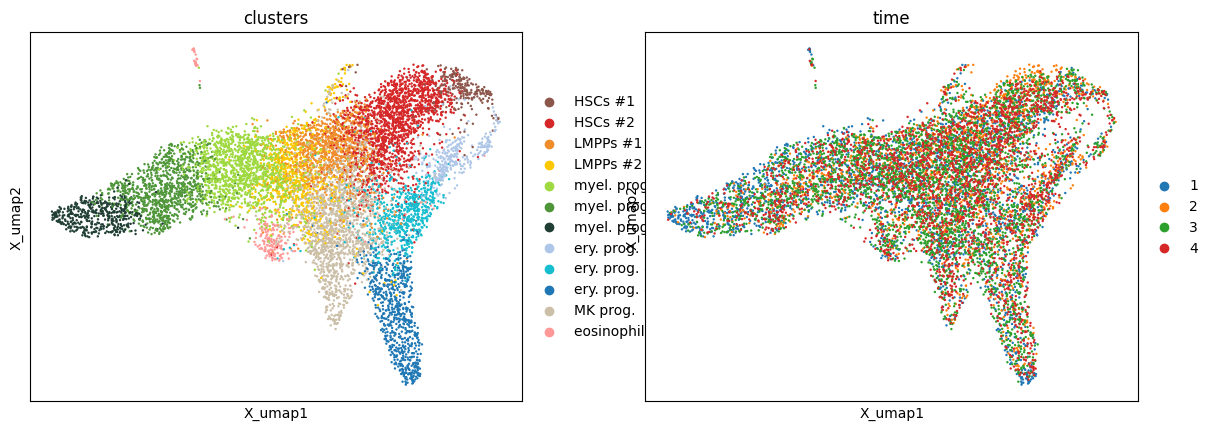

In [225]:
sc.pl.embedding(adata,basis="X_umap", color=["clusters", "time"])

In [6]:
tp = TemporalProblem(adata)

In [7]:
tp = tp.score_genes_for_marginals(
    gene_set_proliferation="mouse", gene_set_apoptosis="mouse")

<Axes: ylabel='Density'>

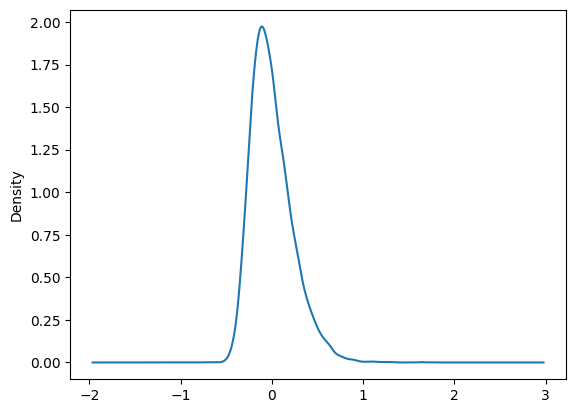

In [8]:
adata.obs["apoptosis"].plot(kind="density")

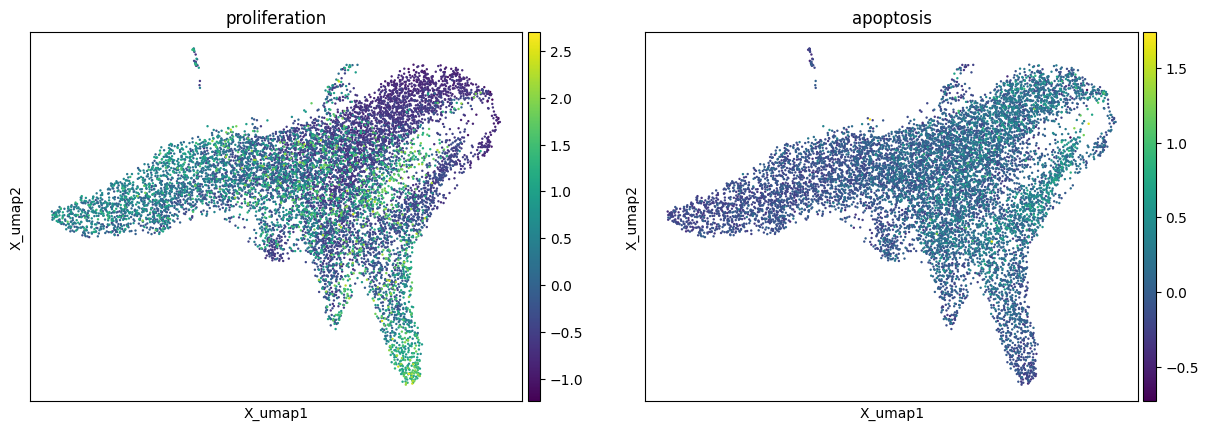

In [9]:
sc.pl.embedding(adata,basis="X_umap",color=["proliferation","apoptosis"])

In [8]:
tp = tp.prepare(time_key='time')

INFO     Ordering Index(['AAACCCAGTGTTCATG-1-control', 'AAACGAACAAGTAGTA-1-control',                               
                'AAACGAACACATTCTT-1-control', 'AAACGAACATGGAACG-1-control',                                        
                'AAACGAACATTCAGGT-1-control', 'AAACGAAGTCACCCTT-1-control',                                        
                'AAACGAAGTGACTCGC-1-control', 'AAACGCTGTCCACTTC-1-control',                                        
                'AAACGCTGTCCTACAA-1-control', 'AAACGCTGTTCCCAAA-1-control',                                        
                ...                                                                                                
                'TTTGGTTAGCATGAAT-1-72h', 'TTTGGTTAGTCGAAAT-1-72h',                                                
                'TTTGGTTGTTGGCCTG-1-72h', 'TTTGGTTTCAAGTCGT-1-72h',                                                
                'TTTGGTTTCTTCGTGC-1-72h', 'TTTGTTGAGGAAGTCC-1-72h',     

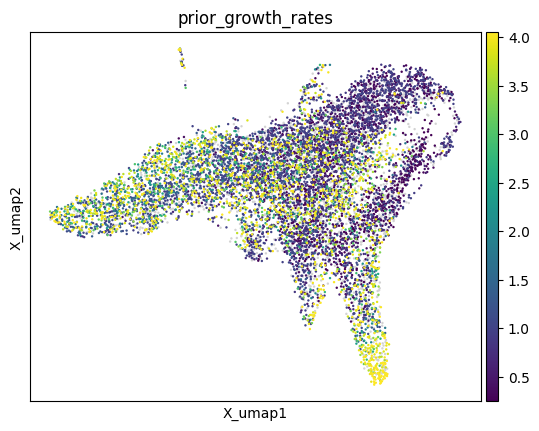

In [9]:
adata.obs["prior_growth_rates"] = tp.prior_growth_rates
#adata.obs["prior_growth_rates"] = 1


sc.pl.embedding(adata, basis="X_umap", color="prior_growth_rates")

In [10]:
tp = tp.solve(epsilon=0.001, tau_a=0.001, tau_b=0.999, scale_cost="mean",)

INFO     Solving `3` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1656, 3457)].                                  
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(2430, 1656)].                                  
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(3457, 2440)].                                  


In [11]:
#adata.obs["prior_growth_rates"] = tp.prior_growth_rates
adata.obs["posterior_growth_rates"] = tp.posterior_growth_rates

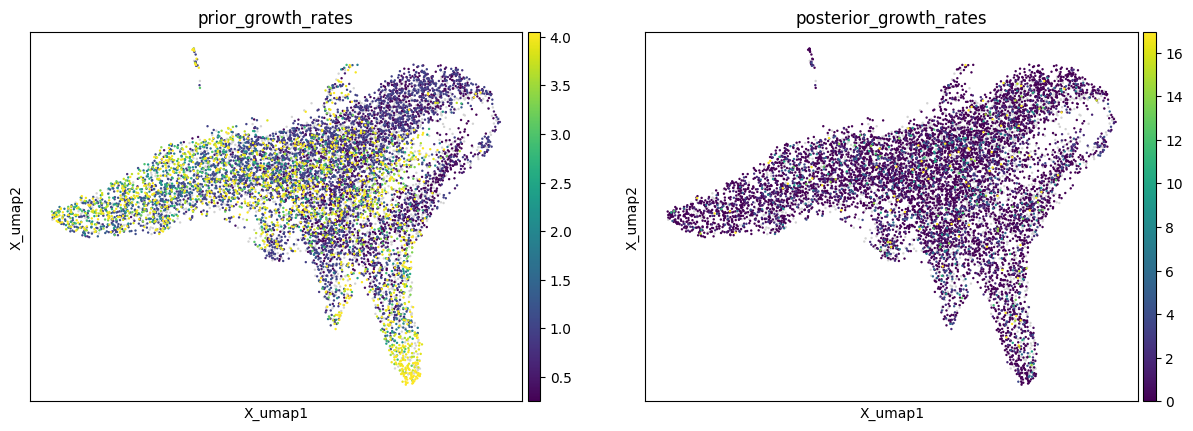

In [12]:
sc.pl.embedding(
    adata,
    basis="X_umap",
    color=["prior_growth_rates", "posterior_growth_rates"],
    vmax="p99",
)

In [13]:
adata.obs["cell_costs_source"] = tp.cell_costs_source
adata.obs["cell_costs_target"] = tp.cell_costs_target

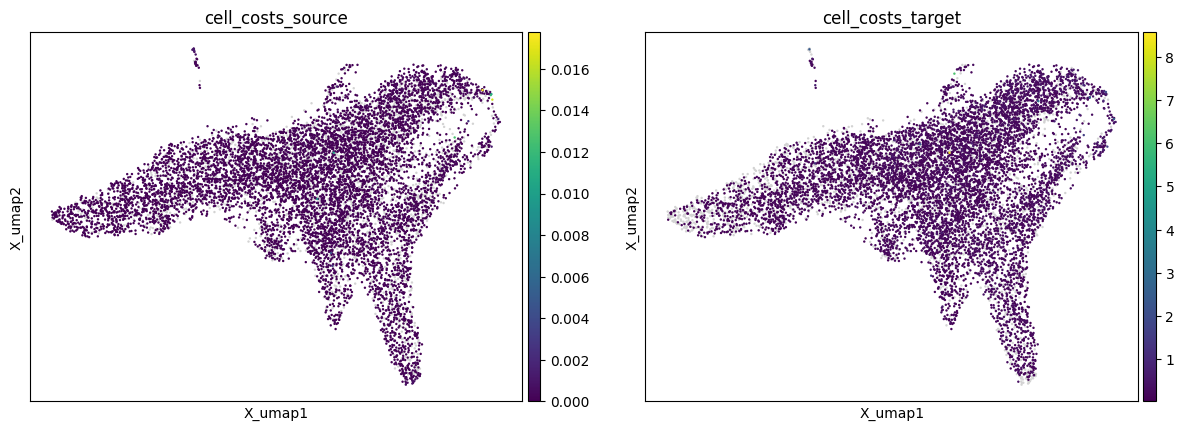

In [14]:
sc.pl.embedding(
    adata, basis="X_umap", color=["cell_costs_source", "cell_costs_target"]
)

In [15]:
ct_desc = tp.cell_transition(
    2, 3, "clusters", "clusters", forward=False, key_added="transitions_2_3"
)
ct_desc = tp.cell_transition(
    1, 2, "clusters", "clusters", forward=False, key_added="transitions_1_2"
)
ct_desc = tp.cell_transition(
    3, 4, "clusters", "clusters", forward=False, key_added="transitions_3_4"
)

In [16]:
ct_desc

,HSCs #1,HSCs #2,LMPPs #1,LMPPs #2,MK prog.,eosinophil prog.,ery. prog. #1,ery. prog. #2,ery. prog. #3,myel. prog. #1,myel. prog. #2,myel. prog. #3
HSCs #1,0.154294,5.752374e-02,1.985874e-02,0.000142,0.004284,0.000000e+00,1.008760e-02,5.238802e-03,0.000000e+00,1.485947e-34,0.000000e+00,0.000000
HSCs #2,0.485339,4.564919e-01,2.154535e-01,0.176690,0.152944,4.409930e-10,7.714072e-02,8.451698e-02,1.133841e-02,1.357728e-02,0.000000e+00,0.000000
LMPPs #1,0.101286,1.906315e-01,3.971276e-01,0.287446,0.071534,3.232749e-02,5.532254e-03,2.518475e-02,8.795776e-05,9.842659e-02,3.400552e-22,0.000000
LMPPs #2,0.000004,4.661230e-02,1.184609e-01,0.172439,0.079939,1.983252e-02,4.291634e-02,3.667570e-02,2.567859e-10,5.883225e-02,1.055515e-09,0.000000
MK prog.,0.070843,1.960726e-01,1.335189e-01,0.132563,0.584150,9.469640e-02,6.795153e-02,1.114349e-01,3.398016e-02,2.241163e-02,0.000000e+00,0.000000
eosinophil prog.,0.016489,3.772378e-03,1.210274e-12,0.006762,0.006316,6.800808e-01,4.207804e-02,2.577036e-02,5.319518e-03,1.292004e-02,5.296657e-03,0.015174
ery. prog. #1,0.089728,1.500511e-02,3.465144e-06,0.011874,0.014731,6.825652e-04,4.846862e-01,1.804508e-01,1.134773e-02,6.006362e-11,0.000000e+00,0.000000
ery. prog. #2,0.066547,2.453194e-02,1.471103e-02,0.008790,0.057305,2.177358e-02,2.695640e-01,3.524844e-01,6.077546e-02,3.258473e-03,0.000000e+00,0.000000
ery. prog. #3,0.000597,3.655762e-07,7.916417e-03,0.025693,0.007308,1.894146e-03,4.327335e-05,1.782433e-01,8.771508e-01,7.319551e-06,0.000000e+00,0.000000
myel. prog. #1,0.014873,9.358151e-03,9.294934e-02,0.164585,0.019701,1.299243e-01,1.682272e-16,1.411761e-10,6.433311e-18,6.328727e-01,1.287620e-01,0.011582


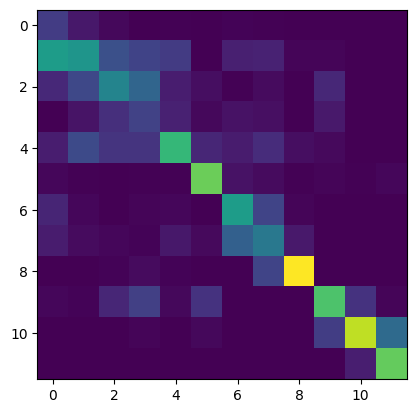

In [17]:
plt.imshow(ct_desc)

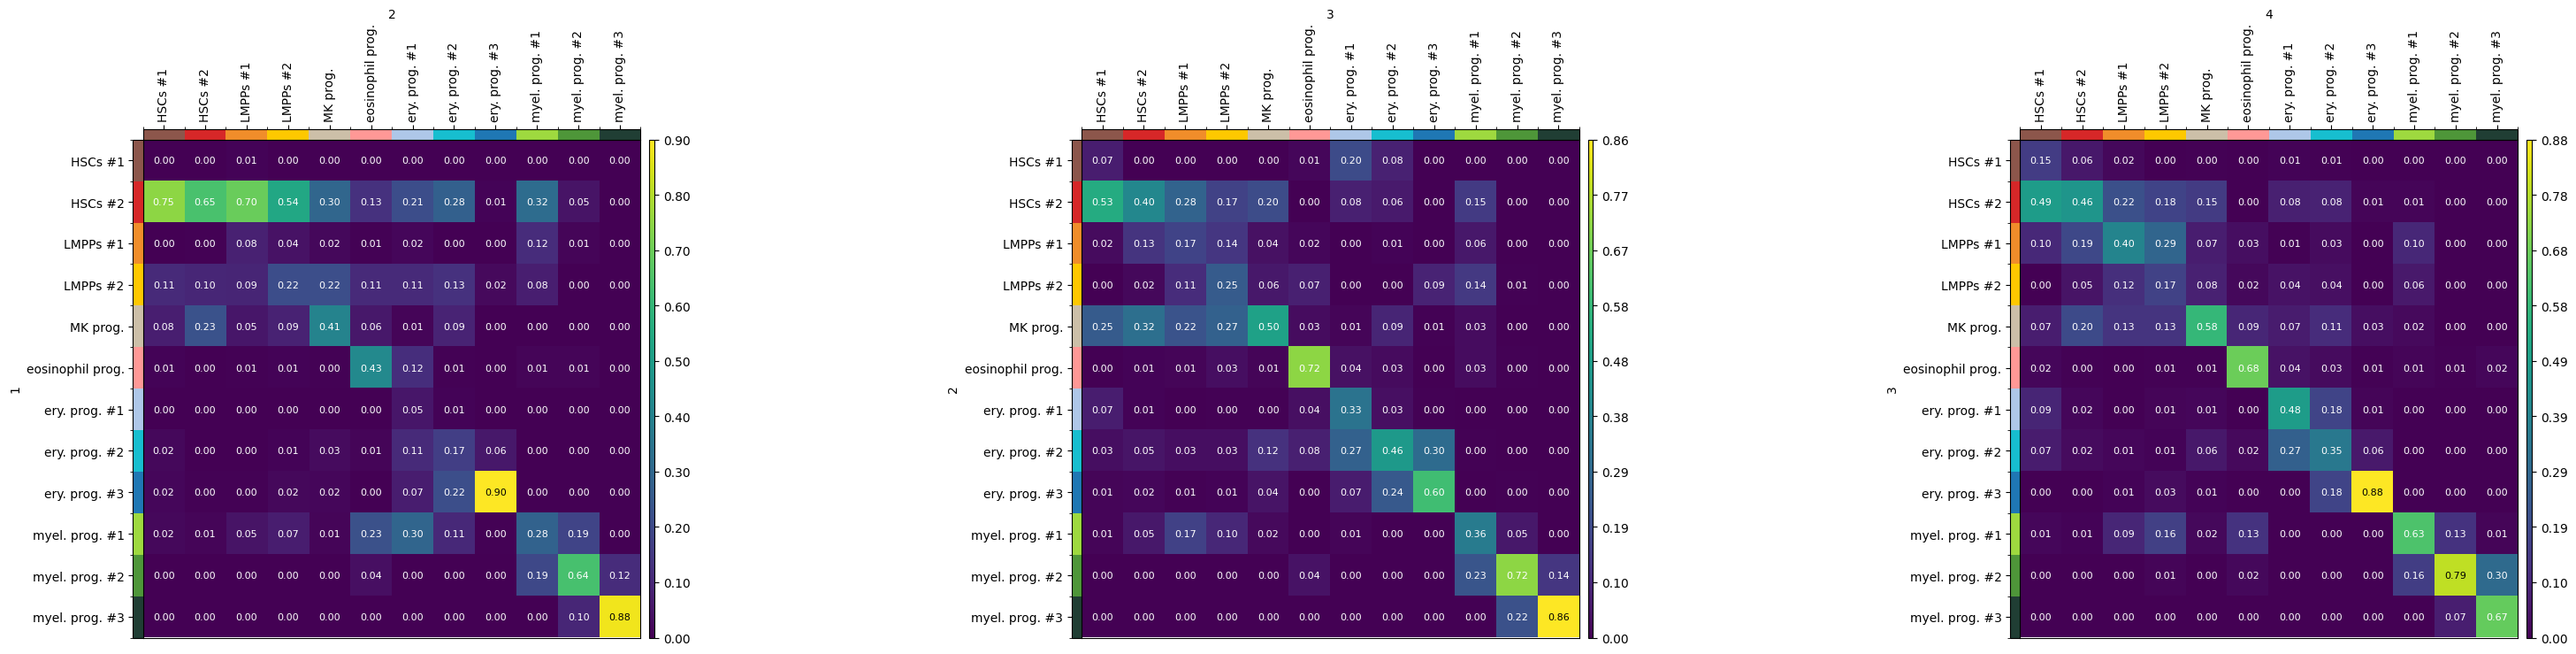

In [18]:
# Create a 1x3 grid of subplots
fig, axes = plt.subplots(ncols=3, figsize=(35, 12))

axes[0] = mtp.cell_transition(
    tp,
    fontsize=8,
    figsize=( 10,10),
    return_fig=True,
    ax=axes[0],
    key="transitions_1_2",
)

axes[1] = mtp.cell_transition(
    tp,
    fontsize=8,
    figsize=(10,10),
    return_fig=True,
    ax=axes[1],
    key="transitions_2_3",
)

axes[2] = mtp.cell_transition(
    tp,
    fontsize=8,
    figsize=(10,10),
    return_fig=True,
    ax=axes[2],
    key="transitions_3_4",
)
fig.subplots_adjust(wspace=0.8)

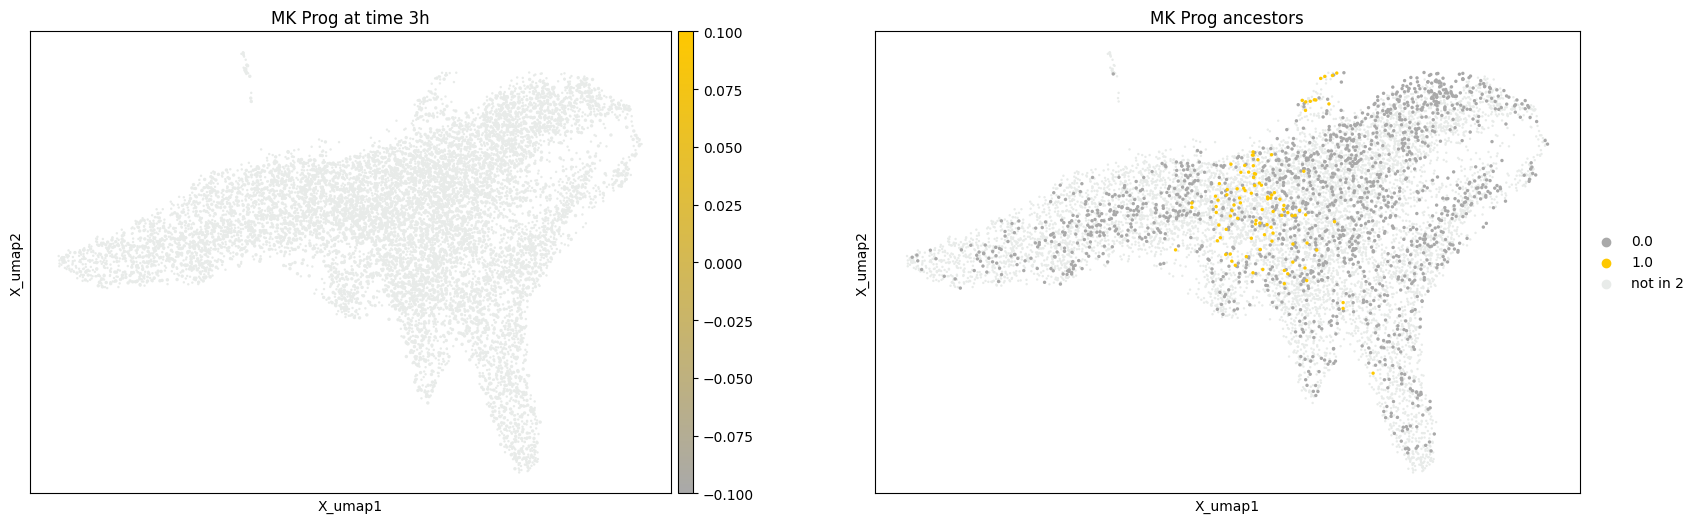

In [19]:
tp.pull(source=1, target=2, data="clusters", subset="LMPPs #2")

fig, axes = plt.subplots(ncols=2, figsize=(20, 6))

axes[0] = mtp.pull(
    tp,
    time_points=[3],
    basis="X_umap",
    ax=axes[0],
    return_fig=True,
    title=["MK Prog at time 3h"],
)
axes[1] = mtp.pull(
    tp,
    time_points=[2],
    basis="X_umap",
    ax=axes[1],
    return_fig=True,
    title=["MK Prog ancestors"],
)

fig.subplots_adjust(wspace=0.2)

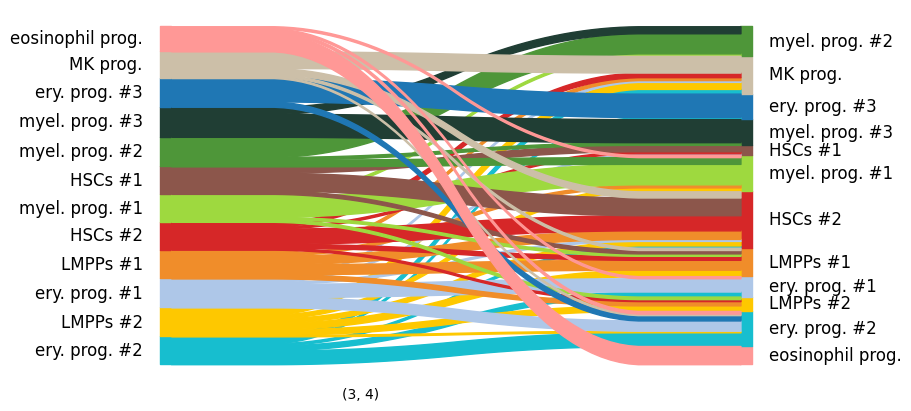

In [20]:
tp.sankey(
    source=3,
    target=4,
    source_groups="clusters",
    target_groups="clusters",
    threshold=0.05,
)
mtp.sankey(tp, dpi=100, figsize=(9, 4))

W = $\min_\gamma <\gamma,M>_F$ + $reg\cdot\Omega(\gamma)$ +$reg_m_1$ KL($\gamma$ 1, a) + $reg_m_2$ KL($\gamma^T$ 1, b)$

        s.t.
             \gamma\geq 0
    where :

    - M is the (dim_a, dim_b) metric cost matrix
    - :math:`\Omega` is the entropic regularization term 
      :math:`\Omega(\gamma)=\sum_{i,j} \gamma_{i,j}\log(\gamma_{i,j})`
    - a and b are source and target unbalanced distributions
    - KL is the Kullback-Leibler divergence

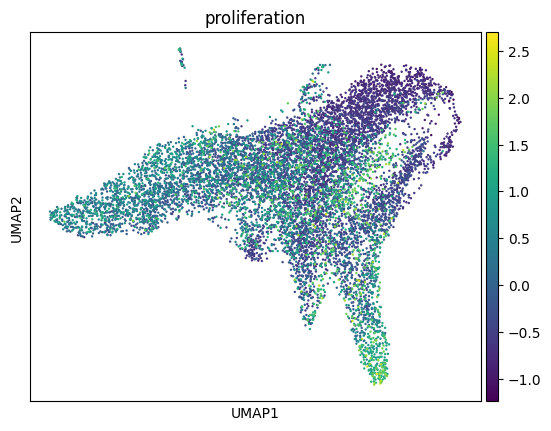

In [22]:
sc.pl.umap(adata,color="proliferation")

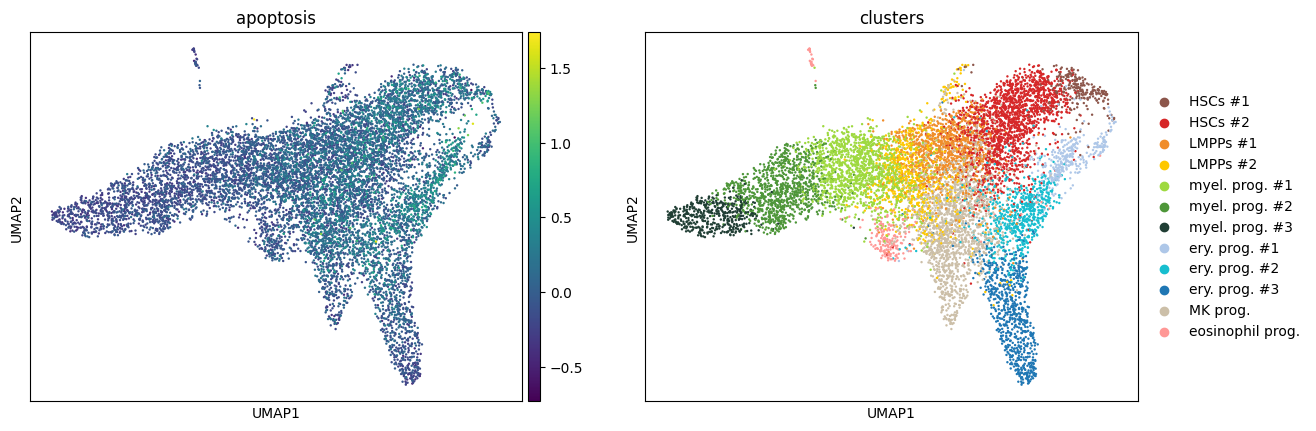

In [40]:
sc.pl.umap(adata,color=(["apoptosis","clusters"]))

In [69]:
adata.obs.clusters.unique().tolist()

['myel. prog. #1',
 'ery. prog. #3',
 'MK prog.',
 'myel. prog. #2',
 'HSCs #1',
 'LMPPs #1',
 'HSCs #2',
 'LMPPs #2',
 'myel. prog. #3',
 'ery. prog. #1',
 'ery. prog. #2',
 'eosinophil prog.']

INFO     Ordering Index(['AAACCCAGTGTTCATG-1-control', 'AAACGAACAAGTAGTA-1-control',                               
                'AAACGAACACATTCTT-1-control', 'AAACGAACATGGAACG-1-control',                                        
                'AAACGAACATTCAGGT-1-control', 'AAACGAAGTCACCCTT-1-control',                                        
                'AAACGAAGTGACTCGC-1-control', 'AAACGCTGTCCACTTC-1-control',                                        
                'AAACGCTGTCCTACAA-1-control', 'AAACGCTGTTCCCAAA-1-control',                                        
                ...                                                                                                
                'TTTGGTTAGCATGAAT-1-72h', 'TTTGGTTAGTCGAAAT-1-72h',                                                
                'TTTGGTTGTTGGCCTG-1-72h', 'TTTGGTTTCAAGTCGT-1-72h',                                                
                'TTTGGTTTCTTCGTGC-1-72h', 'TTTGTTGAGGAAGTCC-1-72h',     

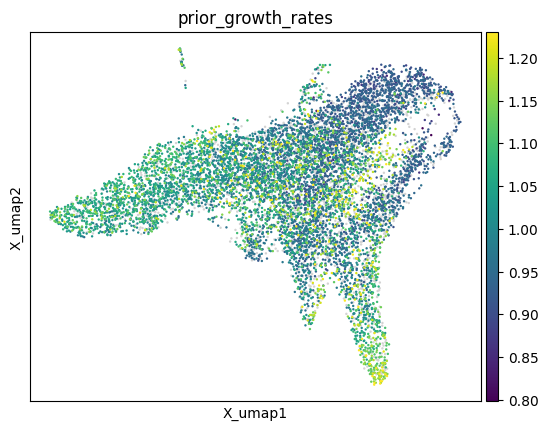

In [55]:
tp = tp.prepare(time_key="time",  marginal_kwargs={"scaling": 10})
adata.obs["prior_growth_rates"] = tp.prior_growth_rates

sc.pl.embedding(adata, basis="X_umap", color="prior_growth_rates", vmax="p99")

# set custom custom matrices

In [13]:
adata

AnnData object with n_obs × n_vars = 9983 × 860
    obs: 'hashtags', 'time', 'clusters', 'n_counts_all', 'n_counts', 'proliferation', 'apoptosis', 'prior_growth_rates'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'clusters_colors', 'hvg', 'log1p'
    obsm: 'X_umap'

In [22]:
rng = np.random.default_rng(seed=42)
obs_names_0 = tp[1,2].adata_src.obs_names
obs_names_1 = tp[1,2].adata_tgt.obs_names

In [25]:
cost_linear_01 = np.abs(rng.normal(size=(len(obs_names_0),len(obs_names_1))))
cost_quad_0 = np.abs(rng.normal(size=(len(obs_names_0),len(obs_names_0))))

np.fill_diagonal(cost_quad_0,0)
cost_quad_1 = np.abs(rng.normal(size=(len(obs_names_1),len(obs_names_1))))
np.fill_diagonal(cost_quad_0, 0)
cost_quad_1 = np.abs(rng.normal(size=(len(obs_names_1), len(obs_names_1))))
np.fill_diagonal(cost_quad_1, 0)

cm_linear = pd.DataFrame(data=cost_linear_01, index=obs_names_0, columns=obs_names_1)
cm_quad_0 = pd.DataFrame(data=cost_quad_0, index=obs_names_0, columns=obs_names_0)
cm_quad_1 = pd.DataFrame(data=cost_quad_1, index=obs_names_1, columns=obs_names_1)

In [26]:
tp[1,2].set_xy(cm_linear,tag="cost_matrix")
tp[1,2].set_x(cm_quad_0,tag="cost_matrix")
tp[1,2].set_y(cm_quad_1,tag="cost_matrix")

INFO     Changing the problem type from 'linear' to 'quadratic (fused)'.                                           


In [27]:
tp = tp.solve(epsilon=0.001, tau_a=0.001, tau_b=0.999, scale_cost="mean",)

INFO     Solving `3` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1656, 3457)].                                  
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(2430, 1656)].                                  
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(3457, 2440)].                                  


In [46]:
tp.prior_growth_rates

,prior_growth_rates
AAACCCAGTCACTGAT-1-3h,0.997320
AAACGCTAGGTCATTC-1-3h,1.009600
AAACGCTCACTAACCA-1-3h,3.650146
AAAGGGCTCTTGGTCC-1-3h,1.164648
AAAGTGATCAGGAAGC-1-3h,0.295996
...,...
TGTTCTAGTCCTCATC-1-72h,NaN
GACAGCCCATACTTTC-1-72h,NaN
AGTACTGCATGCCGGT-1-72h,NaN
TGCAGATTCAATCCAG-1-72h,NaN
